In [15]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import nltk
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as km

import hdbscan
from sklearn.cluster import DBSCAN


# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

### Stemming & tokenizing & Word2vec
- kakao_review_nlp.py 의 rv_tokenizing()을 통해 전처리된 파일 사용

In [16]:
path = "../../datas/"
naver = pd.read_csv(path+"v5_category_re_token_sum.csv")
kakao = pd.read_csv(path+"kakao_review_cat_predict_token_sum.csv")

n_reviews = naver[['highlight_review', 'category']].copy()
n_reviews.rename(columns={"highlight_review": 'review'}, inplace=True)
k_reviews = kakao[['contents', 'category']].copy()
k_reviews.dropna(axis=0, inplace=True)
k_reviews.rename(columns={"contents": 'review'}, inplace=True)

data = pd.concat([n_reviews, k_reviews], axis=0).reset_index()
data

,index,review,category
0,0,데크가 너무 작다,메인시설
1,1,따뜻하다물 자다 나오다,메인시설
2,2,데크도 작고,메인시설
3,3,방이 상당하다 깨끗하다 좋다,메인시설
4,4,데크가 조금 작다,메인시설
...,...,...,...
124702,4248,생기다얼마안되다 깨끗하다\n시에서 운영하다 아니다 사만원이나 받다 매점은 없다 온수...,메인시설
124703,4249,카페 위치랑 쉬다딱좋다곳..\n테이블 의자셋팅 풍경 너무좋다..\n하지만 커피맛은 ...,메인시설
124704,4250,2층 테라스도 있다 주차장 넓다 좋다 정원도 있다 아이들도 놀다 좋다~,부대/공용시설
124705,4251,넓다 한적하다 정원 예쁘다 테라스까지 넘다 좋다^^ \n,부대/공용시설


In [57]:
stopwords = ['',' ''다','좀', '있다', '조금', '요', '되어다', '더', '다' '너', '친', '가자', '아주', '그렇다', '바라','싶다','습니다','좀',
             '및', '...', '도', '수', '나다', '엄청', '것', '점', '등', '등등', '사', '에', '옆','이다','보다', '되다', '항상', '어요'
            , '실', '만', '정', '아', '깨', '안', '없', '무', '또', '시']

new_list = []
for r in range(len(data)):
    try: 
        rv = data["review"].iloc[r]
        rv = rv.split(" ")
        rv.append(data['category'].iloc[r])
        rv = [re.compile('[^가-힣]+').sub("", r) for r in rv]
        rv = [re.compile('[은, 는, 이, 도, 라]+').sub("", r) for r in rv]
        rv = [r.replace(r, "") if len(r)<1 or r in stopwords else r for r in rv]
        new_list.append(rv)

    except:
        new_list.append("")

# vocabs = [word for word in new_list if word not in stopwords and len(word)>1]
print("total words num: ", len(new_list))
data['cat_plus_rv'] = new_list
reviews = data['cat_plus_rv']
model = Word2Vec(reviews, sg=1, # skinp-gram: 중심단어로 주변단어 예측
                 vector_size=200,
                 workers=6, 
                 window=5,      # 중심 단어로부터 좌우 n개까지 학습에 적용
                 min_count=100, # 전체 문서에서 최소 n회 이상 출현 단어로 학습
                 sample=0.001
                ) 

word_vectors = model.wv.vectors

vocabs = list(model.wv.index_to_key)
word_vectors_list = [model.wv[v] for v in vocabs]

print(len(word_vectors), len(vocabs), vocabs)

total words num:  124707
437 437 ['좋다', '', '메인시설', '서비스', '친절하다', '만족', '너무', '사장님', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '위치', '전망', '화장실', '수영장', '자다', '깔끔하다', '하다', '정말', '많다', '다', '가격', '계곡', '만족하다', '없다', '뷰', '샤워실', '개수대', '넘다', '오다', '직원분들', '가깝다', '넓다', '모두', '가다', '샤워장', '경치', '조용하다', '괜찮다', '아쉽다', '방', '음식조식', '매우', '캠핑장', '관리', '따뜻하다', '않다', '비품', '편하다', '친절', '너무좋다', '글램핑', '관리가', '만족스럽다', '뷰가', '진짜', '풍경', '놀다', '아들', '주변', '같다', '불편하다', '너무너무', '사트', '들다', '잘되어다', '내부', '물', '예쁘다', '많', '편의시설', '사장님께서', '청결하다', '카반', '쉬다', '온수', '벌레', '최고다', '바로', '쁘다', '고', '나오다', '바베큐', '안되다', '완전', '좋아하다', '크다', '벌레가', '매점', '최고', '생각보다', '분위기가', '멀다', '다음에', '바다', '예약', '앞', '시원하다', '차다', '경치가', '용하다', '맛있다', '나무', '아니다', '즐겁다', '잘되다', '저렴하다', '숙소', '사모님', '너무친절하다', '잘나오다', '샤워시설', '깨끗', '매너타임', '불', '곳', '힘들다', '난방', '좁다', '경치좋다', '사장님들', '앞에', '바닥', '작다', '시설깨끗하다', '맘에', '물놀', '간격', '굿', '보내다', '부대시설', '공기', '시간', '주인분', '캠핑', '주인분들', '굉장하다', '해주다', '비싸다', '재밌다', '내외분', '직원분', '화장

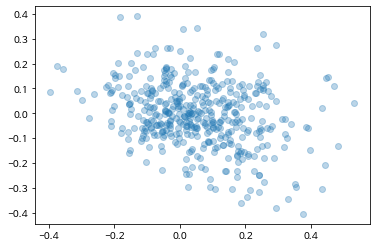

In [58]:
plt.scatter(word_vectors.T[0], word_vectors.T[1], alpha=0.3)
plt.show()

### 차원축소를 하지 않으면 전혀 군집이 되지 않음

/home/hj/anaconda3/envs/nlp/lib/python3.8/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


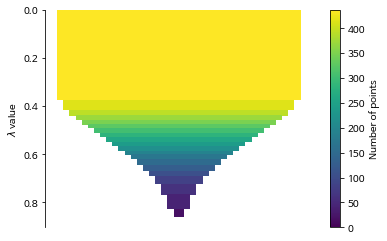

In [59]:
import hdbscan
from sklearn.cluster import DBSCAN

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(word_vectors)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [60]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=4).fit(word_vectors)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(word_vectors)

# 데이터 프레임 만들기
df = pd.DataFrame(word_vectors)
df["labels"] = pred_hds
df["words"] = vocabs

print(np.unique(df["labels"]))
df.tail(2)

[-1  0  1  2  3  4]


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,labels,words
435,-0.207078,0.011382,-0.004416,0.023290,0.093633,0.106740,0.030951,0.104441,-0.119937,0.290435,...,-0.355997,-0.111165,0.298600,0.16182,0.133283,-0.238598,-0.002460,-0.099414,-1,중
436,0.146593,-0.083112,0.103086,0.064581,0.110618,-0.074596,-0.165069,0.141669,0.057916,0.142625,...,-0.130380,-0.219808,-0.031337,0.07408,0.051558,-0.226944,0.013837,-0.145387,-1,스파


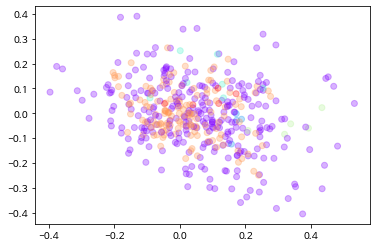

In [61]:
plt.scatter(df[0], df[1], c=df["labels"], cmap="rainbow", alpha=0.3)
plt.show()

In [62]:
for idx in np.unique(df["labels"]):
    print(f"Group{idx}\n",df[df["labels"]==idx]['words'].tolist())

Group-1
 ['좋다', '', '메인시설', '서비스', '친절하다', '만족', '너무', '사장님', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '위치', '전망', '화장실', '수영장', '자다', '깔끔하다', '하다', '많다', '다', '가격', '계곡', '만족하다', '없다', '뷰', '샤워실', '개수대', '오다', '가깝다', '넓다', '모두', '가다', '샤워장', '조용하다', '괜찮다', '아쉽다', '방', '음식조식', '매우', '캠핑장', '관리', '따뜻하다', '않다', '비품', '편하다', '친절', '너무좋다', '글램핑', '관리가', '만족스럽다', '뷰가', '진짜', '놀다', '아들', '주변', '같다', '불편하다', '너무너무', '사트', '들다', '잘되어다', '내부', '물', '예쁘다', '많', '편의시설', '사장님께서', '청결하다', '카반', '쉬다', '온수', '벌레', '최고다', '바로', '쁘다', '나오다', '바베큐', '안되다', '완전', '좋아하다', '크다', '벌레가', '매점', '생각보다', '분위기가', '멀다', '다음에', '바다', '예약', '앞', '시원하다', '용하다', '맛있다', '즐겁다', '잘되다', '저렴하다', '숙소', '너무친절하다', '잘나오다', '샤워시설', '깨끗', '매너타임', '불', '힘들다', '난방', '좁다', '앞에', '바닥', '작다', '시설깨끗하다', '맘에', '물놀', '간격', '보내다', '부대시설', '공기', '시간', '굉장하다', '해주다', '비싸다', '재밌다', '사장님친절하다', '마음에', '가성비', '가격대비', '부족하다', '심하다', '데크', '공간', '계곡물', '너', '분들', '에어컨', '냄새', '애들', '분위기좋다', '멋지다', '잘하다', '그늘', '냄새가', '편리하다', '바다가', '침구', '편안하다', '가

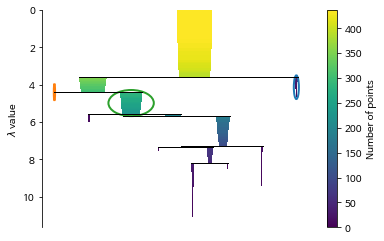

In [63]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(word_vectors)
pca_df = pd.DataFrame(pca_fit, index=vocabs, columns=['x', 'y'])

clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(pca_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [64]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True).fit(pca_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(pca_df)

# 데이터 프레임 만들기
df2 = pd.DataFrame(pca_df)
df2["labels"] = pred_hds

print(np.unique(df2["labels"]), len(df2))
df2.tail(2)

[-1  0  1] 437


,x,y,labels
중,-0.061065,-0.103571,1
스파,-0.034679,-0.474811,1


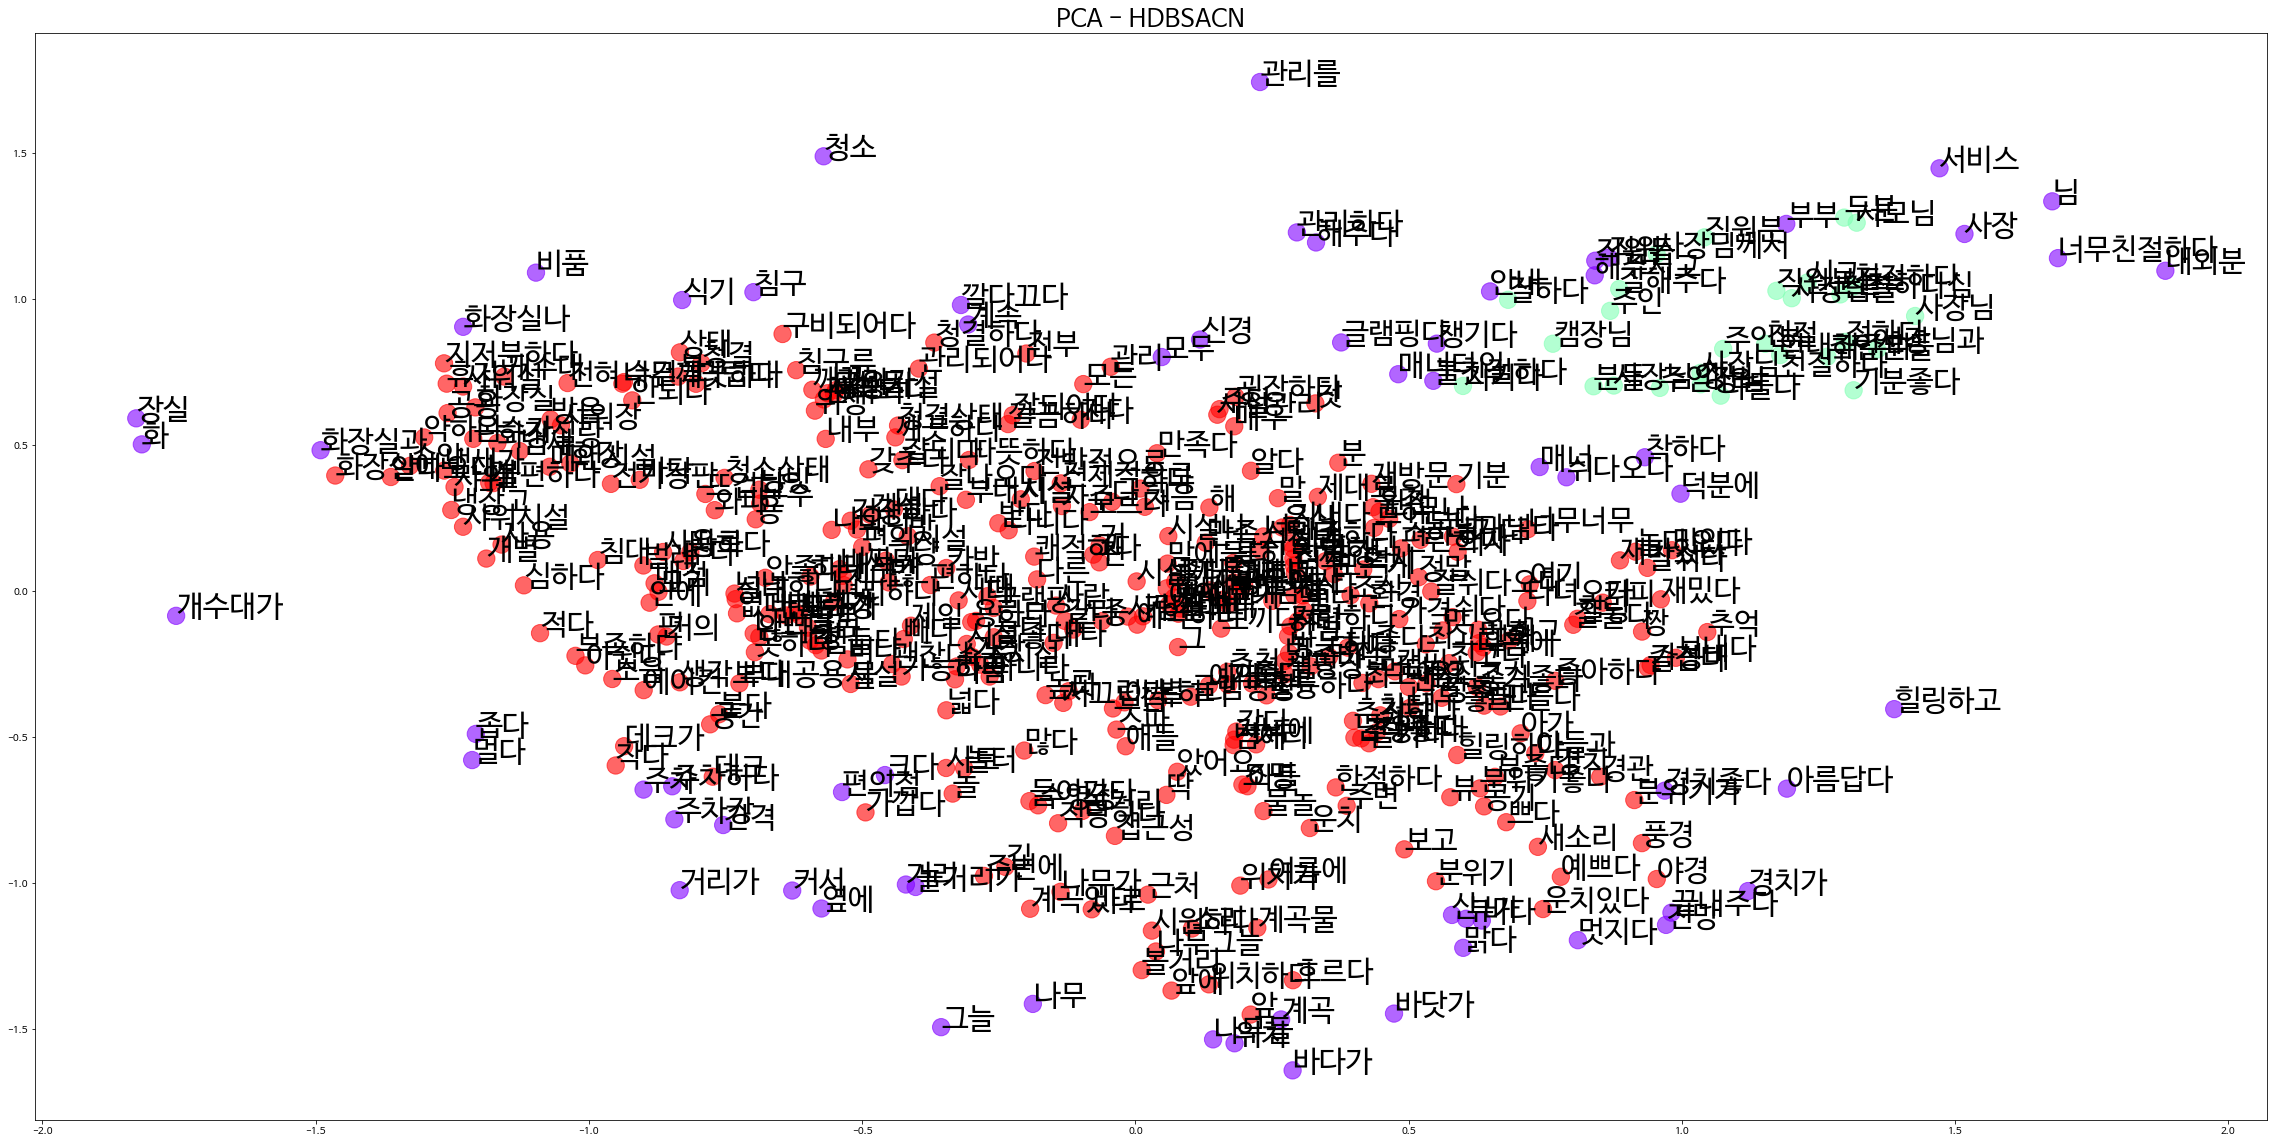

In [65]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
plt.scatter(df2["x"], df2["y"], c= df2["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df2.index):
    plt.annotate(v, xy=(df2["x"][i], df2["y"][i]), fontsize=30)

plt.show()

In [66]:
for idx in np.unique(df2["labels"]):
    print(f"Group{idx}\n",df2[df2["labels"]==idx].index.tolist())

Group-1
 ['서비스', '위치', '전망', '계곡', '모두', '비품', '뷰가', '크다', '멀다', '바다', '경치가', '나무', '너무친절하다', '매너타임', '좁다', '경치좋다', '간격', '해주다', '내외분', '화장실과', '멋지다', '그늘', '바다가', '침구', '청소', '직원들', '거리', '착하다', '개수대가', '거리가', '힐링하고', '관리하다', '사장', '옆에', '주차', '끝내주다', '바닷가', '관리를', '아름답다', '직원', '놀거리가', '덕분에', '부부', '커서', '화', '챙기다', '식기', '해주시고', '나무들', '화장실나', '불친절하다', '계속', '편의점', '님', '깔다끄다', '매너', '쉬다오다', '장실', '신경', '맑다', '주차장', '주차하다', '글램핑다', '안내', '산']
Group0
 ['친절하다', '사장님', '직원분들', '친절', '사장님께서', '사모님', '사장님들', '주인분', '주인분들', '직원분', '사장님친절하다', '주인', '분들', '잘하다', '잘해주다', '사장님과', '캠장님', '사장님의', '지키다', '두분', '친절하다심', '다들다', '절하다', '주인장님', '안내해주다', '장님', '기분좋다', '시고']
Group1
 ['좋다', '', '메인시설', '만족', '너무', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '화장실', '수영장', '자다', '깔끔하다', '하다', '정말', '많다', '다', '가격', '만족하다', '없다', '뷰', '샤워실', '개수대', '넘다', '오다', '가깝다', '넓다', '가다', '샤워장', '경치', '조용하다', '괜찮다', '아쉽다', '방', '음식조식', '매우', '캠핑장', '관리', '따뜻하다', '않다', '편하다', '너무좋다', '글램핑', '관리가', '만족스럽다', '진짜', '풍경', '놀다'

### TSNE 축소법

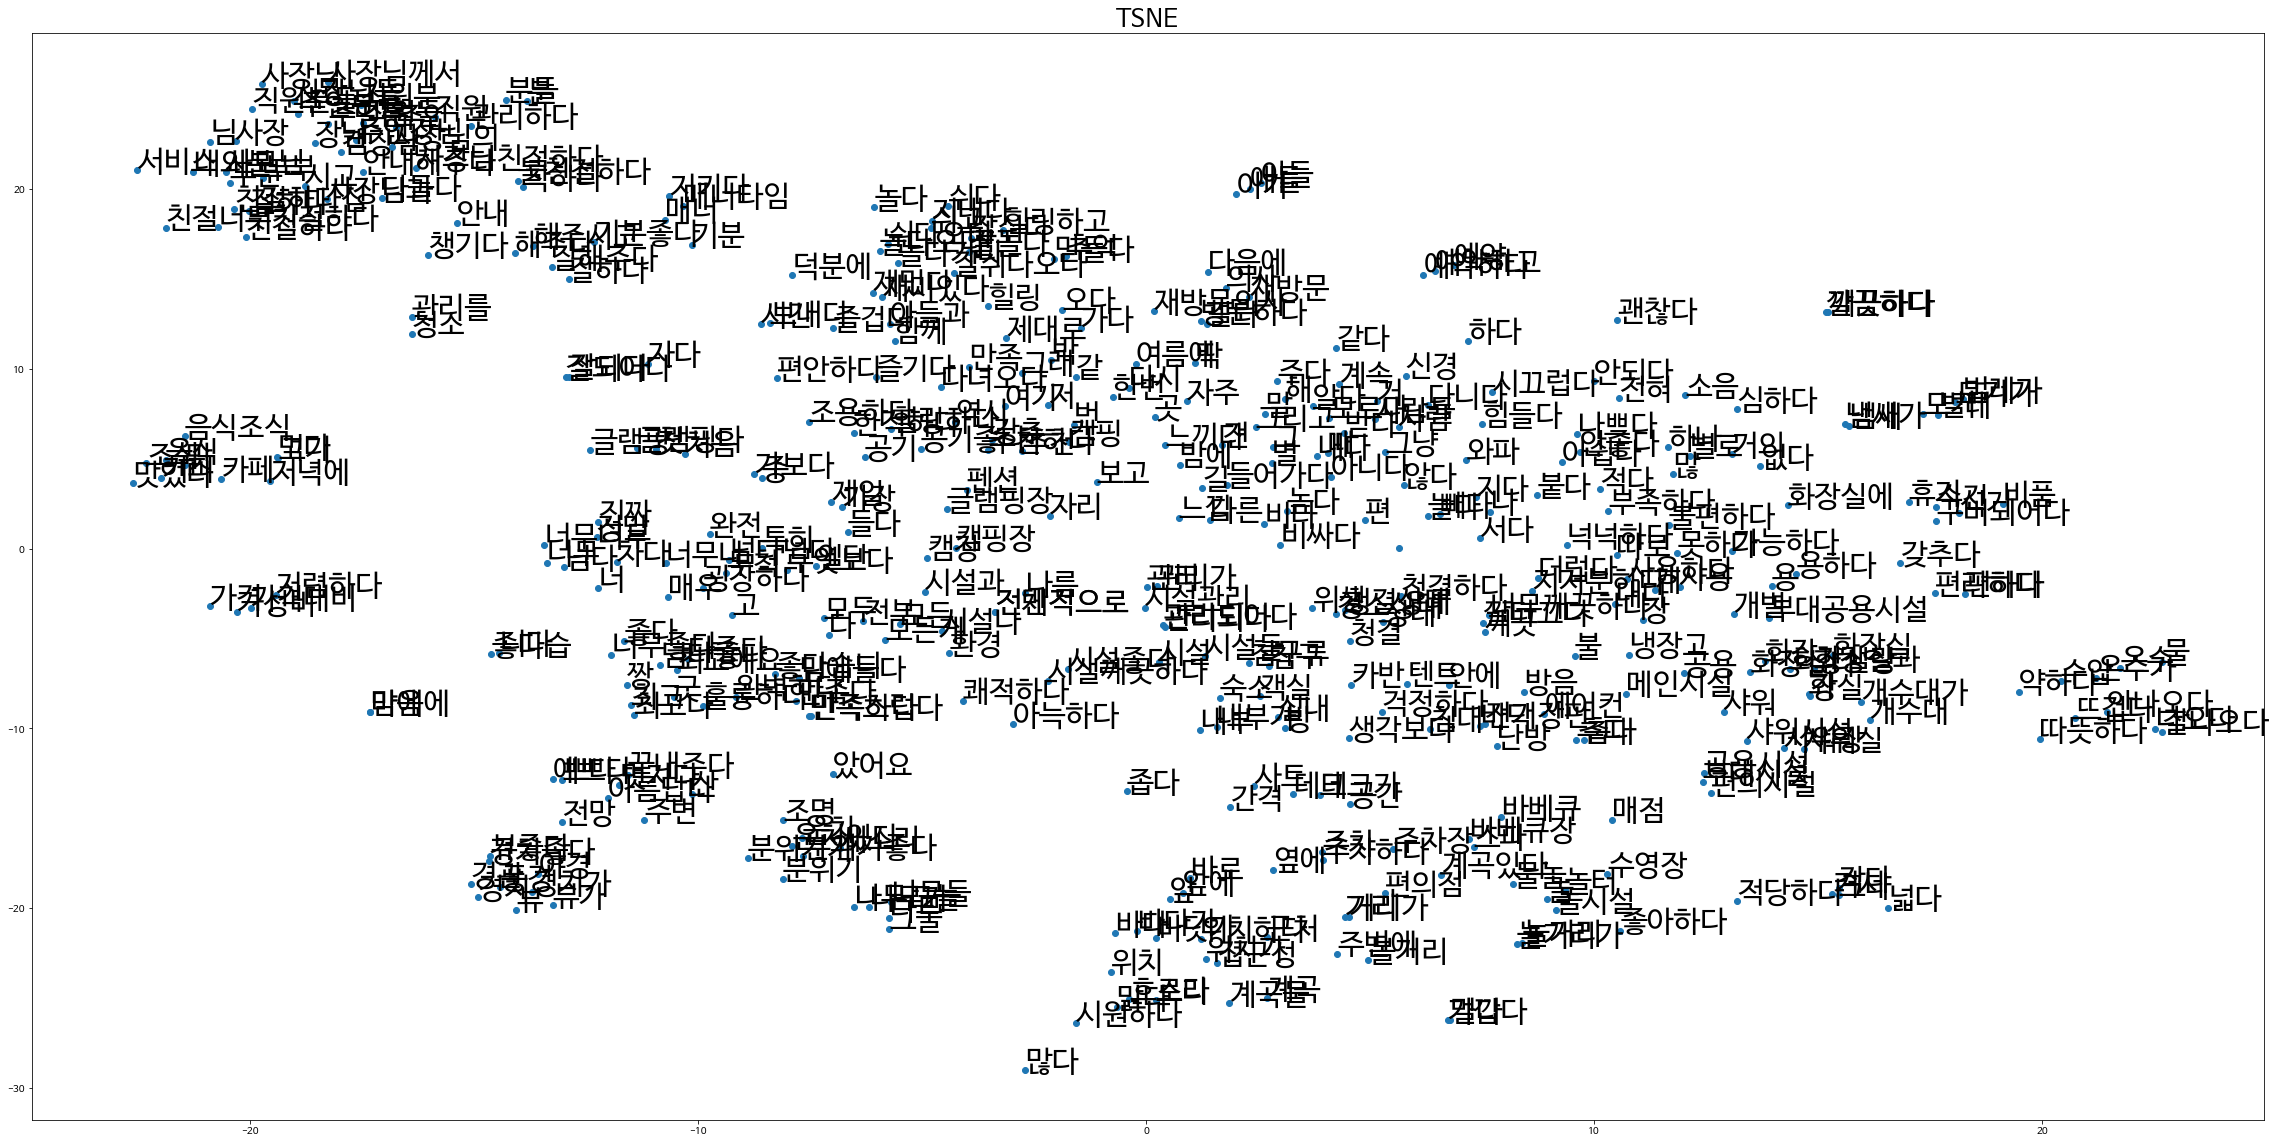

In [67]:
tsne = TSNE(learning_rate=100)
tsne_fit = tsne.fit_transform(word_vectors)
tsne_df = pd.DataFrame(tsne_fit, index=vocabs, columns=['x', 'y'])

plt.figure(figsize=(40, 20))
plt.title("TSNE", fontsize= 25)
plt.scatter(tsne_df["x"], tsne_df["y"])

for word, pos in tsne_df.iterrows():
    plt.annotate(word, pos, fontsize=30)
plt.show()

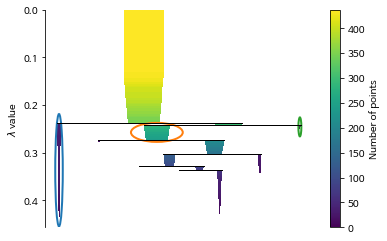

In [68]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(tsne_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [69]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5,
                            cluster_selection_epsilon=0.4,
                            gen_min_span_tree=True,
                            match_reference_implementation=True).fit(tsne_df)
 
# 예측 데이터 생성
pred_hds = model_hds.fit_predict(tsne_df)

# 데이터 프레임 만들기
df3 = pd.DataFrame(tsne_df)
df3["labels"] = pred_hds

print(np.unique(df3["labels"]), len(df3))
df3.tail(2)

[-1  0  1] 437


,x,y,labels
중,-8.578480,3.926640,1
스파,7.308658,-16.568106,1


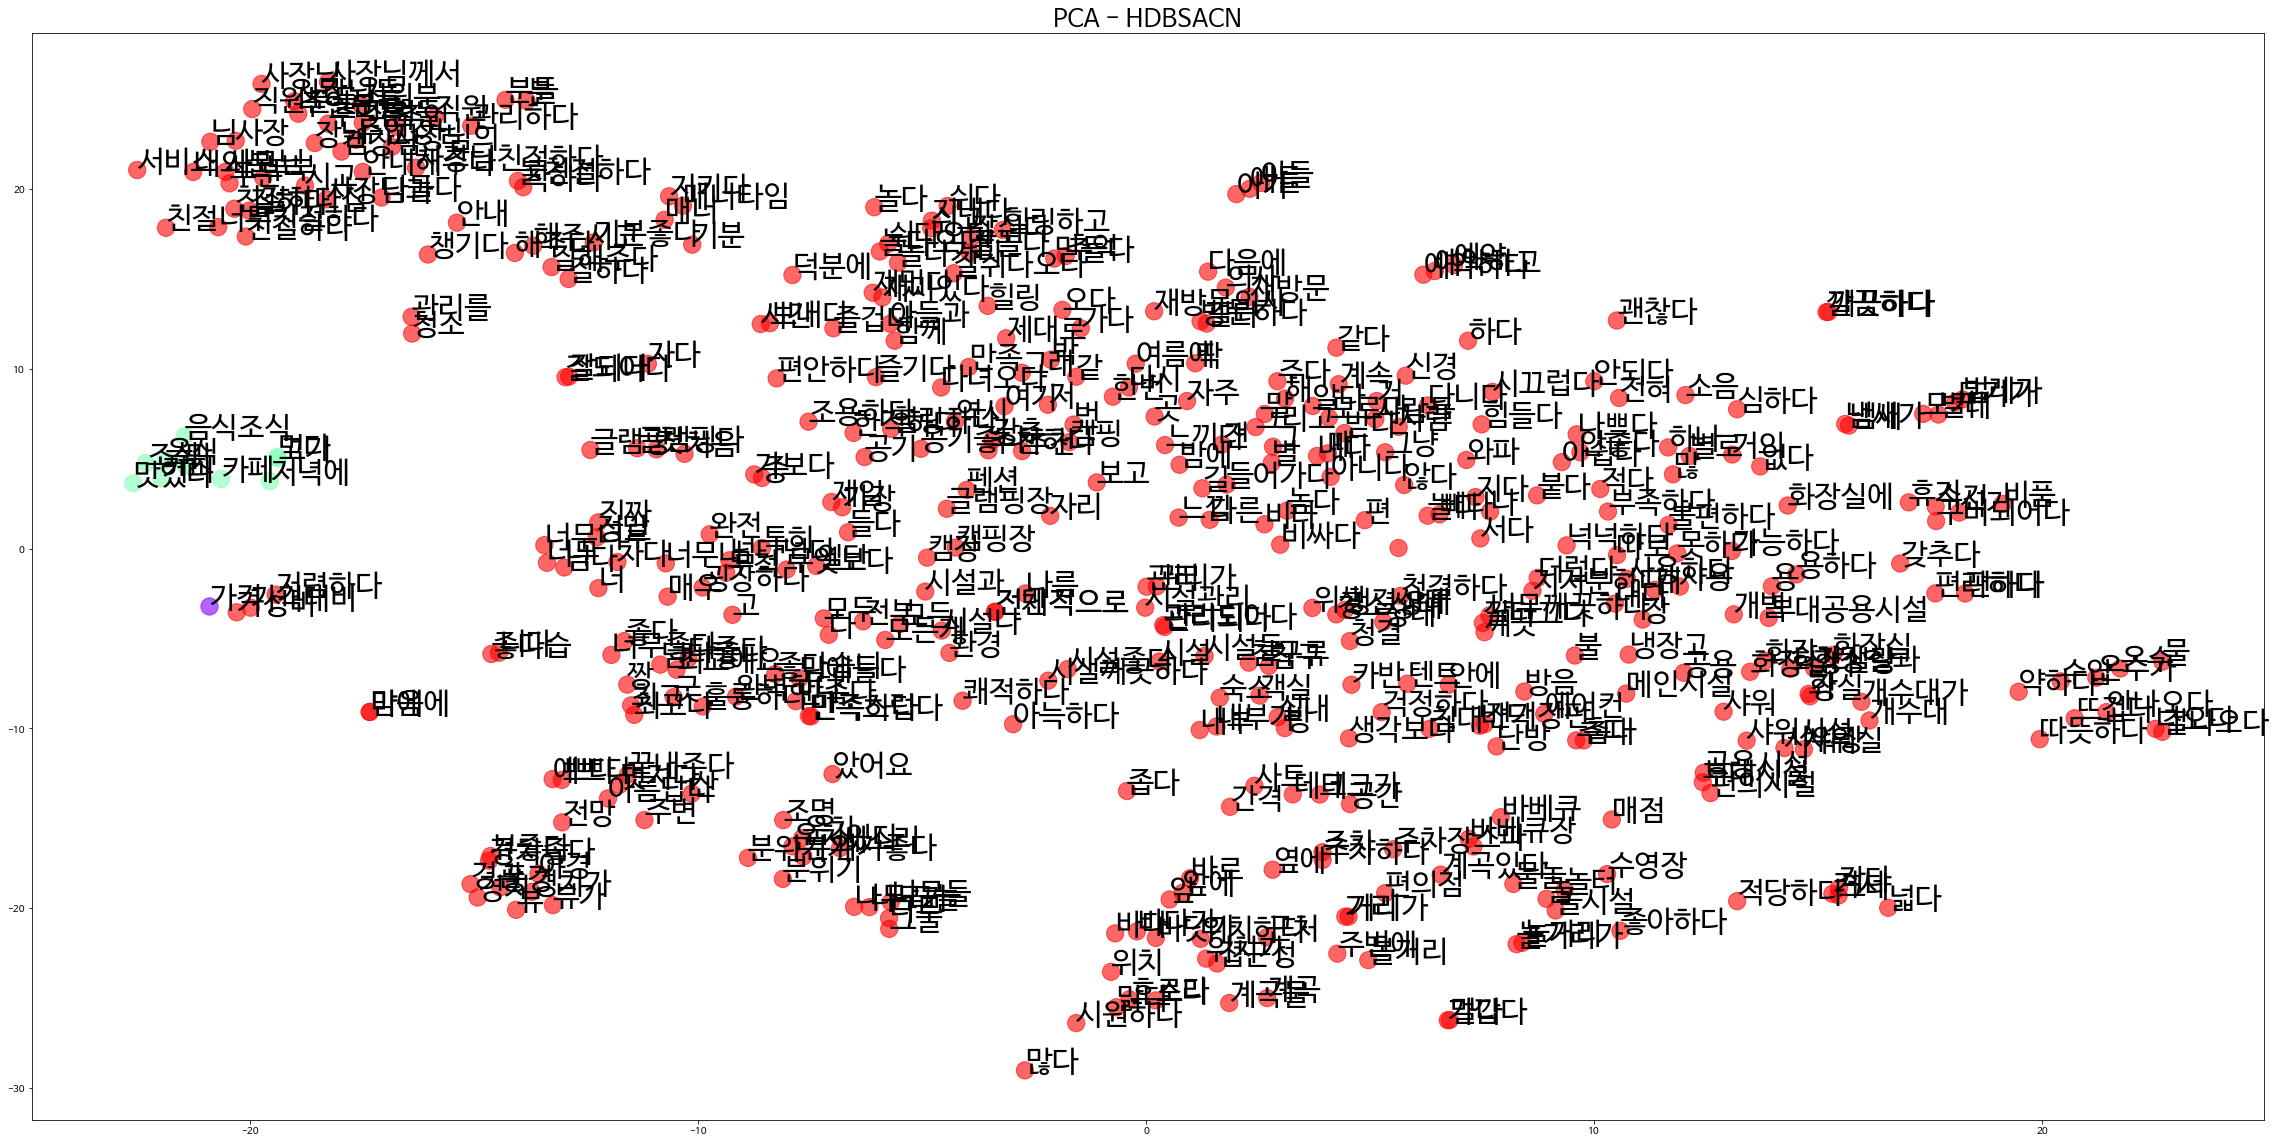

In [70]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
plt.scatter(df3["x"], df3["y"], c= df3["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df3.index):
    plt.annotate(v, xy=(df3["x"][i], df3["y"][i]), fontsize=30)

plt.show()

In [71]:
for idx in np.unique(df3["labels"]):
    print(f"Group{idx}\n",df3[df3["labels"]==idx].index.tolist())

Group-1
 ['가격']
Group0
 ['음식조식', '맛있다', '조식', '먹다', '음식', '맛', '고기', '저녁에', '카페', '커피']
Group1
 ['좋다', '', '메인시설', '서비스', '친절하다', '만족', '너무', '사장님', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '위치', '전망', '화장실', '수영장', '자다', '깔끔하다', '하다', '정말', '많다', '다', '계곡', '만족하다', '없다', '뷰', '샤워실', '개수대', '넘다', '오다', '직원분들', '가깝다', '넓다', '모두', '가다', '샤워장', '경치', '조용하다', '괜찮다', '아쉽다', '방', '매우', '캠핑장', '관리', '따뜻하다', '않다', '비품', '편하다', '친절', '너무좋다', '글램핑', '관리가', '만족스럽다', '뷰가', '진짜', '풍경', '놀다', '아들', '주변', '같다', '불편하다', '너무너무', '사트', '들다', '잘되어다', '내부', '물', '예쁘다', '많', '편의시설', '사장님께서', '청결하다', '카반', '쉬다', '온수', '벌레', '최고다', '바로', '쁘다', '고', '나오다', '바베큐', '안되다', '완전', '좋아하다', '크다', '벌레가', '매점', '최고', '생각보다', '분위기가', '멀다', '다음에', '바다', '예약', '앞', '시원하다', '차다', '경치가', '용하다', '나무', '아니다', '즐겁다', '잘되다', '저렴하다', '숙소', '사모님', '너무친절하다', '잘나오다', '샤워시설', '깨끗', '매너타임', '불', '곳', '힘들다', '난방', '좁다', '경치좋다', '사장님들', '앞에', '바닥', '작다', '시설깨끗하다', '맘에', '물놀', '간격', '굿', '보내다', '부대시설', '공기', '시간', '주인분', '캠핑', '주인분들', '굉장하